# Configure Phenotype Parameters

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
import torch
# Verify acess to GPU
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))
    print("CUDA version (runtime):", torch.version.cuda)


PyTorch version: 2.7.0+cu126
CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA RTX A4000
CUDA version (runtime): 12.6


In [4]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.align import apply_custom_offsets
from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.phenotype.align_channels import align_phenotype_channels
from lib.shared.segment_cellpose import estimate_diameters, segment_cellpose
from lib.shared.segment_microsam import segment_microsam
# from lib.shared.segment_stardist import segment_stardist
from lib.phenotype.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.shared.extract_phenotype_minimal import extract_phenotype_minimal
from lib.phenotype.identify_vacuoles import segment_vacuoles, create_vacuole_boundary_visualization
from lib.phenotype.extract_phenotype_cp_multichannel import (
    extract_phenotype_cp_multichannel,
)
from lib.phenotype.extract_phenotype_vacuoles import extract_phenotype_vacuoles

## <font color='red'>SET PARAMETERS</font>

### Parameters for testing phenotype processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.

In [5]:
# parameters for testing
TEST_PLATE = 1
TEST_WELL = "A3"
TEST_TILE = 4020
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ["DAPI", "ConA", "Stat6", "Mitotracker", "DAPI2", "NHS_ester", "DAPI3", "Tubulin", "WGA", "cMYC", "CDPK1"]
CHANNEL_CMAPS = ["pure_cyan", "pure_green", "pure_red", "pure_yellow", "pure_blue", "pure_green", "pure_blue", "pure_green", "pure_red", "pure_yellow", "pure_magenta"]

# parameters for feature extraction
FOCI_CHANNEL = None

In [6]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# Create and display micropanel of corrected images
print("Example corrected image:")
corrected_microimages = [
    Microimage(
        corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(corrected_image.shape[0])
]
corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
plt.show()

Loading test image...
Applying illumination correction...


FileNotFoundError: [Errno 2] No such file or directory: '/lab/solexa_lourido/USERS/AK/Nebo/nebo-analysis/analysis/preprocess/ic_fields/phenotype/P-1_W-A3__ic_field.tiff'

## <font color='red'>SET PARAMETERS</font>

### Aligning (optional)

- `ALIGN`: Whether to conduct alignment. This is suggested **unless** each image is captured with each channel consecutively. 
- `TARGET`: Index of the channel that other channels will be aligned to.
- `SOURCE`: Index of the channel to align with the target.
- `RIDERS`: Additional channel indices that should follow the same alignment as the source channel.
- `REMOVE_CHANNEL`: Specifies whether to remove channels after alignment. In the case of duplicate channels that are used to align the image, should be set to `source`.

In [ ]:
# corrected_image_stable = corrected_image.copy()

In [ ]:
# Set alignment parameters 
ALIGN = True

# Define single alignment configuration for all wells with multiple steps
ALIGNMENTS = {
    1: {
        "steps": [
            # First alignment step
            {
                "target": 0,  # DAPI from first round
                "source": 4,  # DAPI2 (assuming this is position 5)
                "riders": [5],  # Other channels in second round
                "remove_channel": "source"  # Remove DAPI2 after alignment
            },
            # Third alignment step
            {
                "target": 0,  # DAPI from first round
                "source": 5,  # DAPI3 (assuming this is position 10)
                "riders": [6, 7, 8, 9],  # Other channels in third round
                "remove_channel": "source"  # Remove DAPI3 after alignment
            },
        ]
    }
}

In [ ]:
# CHANNEL_NAMES = ["DAPI", "ConA", "Mitotracker", "Stat6", "DAPI2", "NHS_ester", "DAPI3", "Tubulin", "cMYC", "WGA", "CDPK1"]
# CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_yellow", "pure_blue", "pure_green", "pure_blue", "pure_green", "pure_red", "pure_yellow", "pure_magenta"]

# corrected_image = corrected_image_stable.copy()

if ALIGN:
    print("Aligning channels...")
    # Get alignment configuration for the current plate
    plate_config = ALIGNMENTS.get(TEST_PLATE)
    
    if plate_config:
        # Start with the corrected image
        aligned_image = corrected_image
        
        # Check if this is a multi-step alignment (has "steps" key)
        if "steps" in plate_config:
            print(f"Performing multi-step alignment for plate {TEST_PLATE}...")
            
            # Apply each alignment step in sequence
            for step_num, step in enumerate(plate_config["steps"], 1):
                print(f"  Step {step_num}: Aligning {step['target']} (target) with {step['source']} (source)")
                aligned_image,_ = align_phenotype_channels(
                    aligned_image,
                    target=step["target"],
                    source=step["source"],
                    riders=step["riders"],
                    remove_channel=step["remove_channel"],
                )
                # CHANNEL_NAMES.pop(step["source"])
                # CHANNEL_CMAPS.pop(step["source"])
        else:
            # Single-step alignment
            print(f"Performing single-step alignment for plate {TEST_PLATE}...")
            aligned_image,_ = align_phenotype_channels(
                corrected_image,
                target=plate_config["target"],
                source=plate_config["source"],
                riders=plate_config["riders"],
                remove_channel=plate_config["remove_channel"],
            )
    else:
        # No configuration found for this plate
        print(f"Warning: No alignment configuration found for plate {TEST_PLATE}")
        aligned_image = corrected_image
else:
    aligned_image = corrected_image

In [ ]:
# Custom alignment parameters
ALIGN_CUSTOM = True
CUSTOM_CHANNELS = ["Tubulin", "cMYC", "WGA", "CDPK1"]  # Channels to apply custom offset to
CUSTOM_OFFSET_YX = (-4, 10)  # (y, x) offset to apply


# Derive custom alignment indexes
if ALIGN_CUSTOM:
    CUSTOM_CHANNEL_INDEXES = [CHANNEL_NAMES.index(c) for c in CUSTOM_CHANNELS]

In [ ]:
# Apply custom offsets after traditional alignment
if ALIGN_CUSTOM:
    print("Applying custom channel offsets...")
    aligned_image = apply_custom_offsets(
        aligned_image,
        offset_yx=CUSTOM_OFFSET_YX,
        channels=CUSTOM_CHANNEL_INDEXES
    )

In [ ]:
CHANNEL_NAMES, CHANNEL_CMAPS

## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", or "stardist" for cell segmentation.

#### Common Parameters
- `CYTO_CHANNEL`: Channel to use for cell detection (typically "PHALLOIDIN")
- `HELPER_CHANNEL`: Optional channel to use for cell detection. Set to None if you only want to use CYTO_CHANNEL only.
- `GPU`: Set to True to use GPU acceleration (if available)
- `RECONCILE`: Method for reconciling nuclei and cell masks (typically "contained_in_cells", which allows more than one nucleus per cell and is useful for cells that are dividing)

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use (if CPSAM was re-trained). Default is "cpsam".
- `FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4. Range 0.1 to 3.0.
- `CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0. Range –6.0 to +6.0.
- Note: Nuclei and cell diameters will be estimated automatically.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".
- `POINTS_PER_SIDE`: Number of points to sample along each side of the image. Default is 32.
- `POINTS_PER_BATCH`: Number of points to process in one batch. Default is 16.
- `STABILITY_SCORE_THRESH`: Threshold for stability score. Default is 0.95.
- `PRED_IOU_THRESH`: Threshold for predicted IoU. Default is 0.88.

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `PROB_THRESH`: Probability threshold for segmentation. Default is 0.479071.
- `NMS_THRESH`: Non-maximum suppression threshold. Default is 0.3.

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [ ]:
# Common parameters
CYTO_CHANNEL = "ConA"
GPU = False
RECONCILE = "contained_in_cells"
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

if SEGMENTATION_METHOD == "cellpose":
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cpsam"
    HELPER_CHANNEL = "Tubulin"
    HELPER_INDEX = CHANNEL_NAMES.index(HELPER_CHANNEL)
    NUCLEI_FLOW_THRESHOLD = 0.4
    NUCLEI_CELLPROB_THRESHOLD = 0
    CELL_FLOW_THRESHOLD = 0.4 
    CELL_CELLPROB_THRESHOLD = 1 

    # print("Estimating optimal cell and nuclei diameters...")
    # NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
    #     corrected_image,
    #     dapi_index=DAPI_INDEX,
    #     cyto_index=CYTO_INDEX,
    #     cyto_model=CELLPOSE_MODEL,
    # )

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"
    POINTS_PER_SIDE = 32
    POINTS_PER_BATCH = 16
    STABILITY_SCORE_THRESH = 0.95
    PRED_IOU_THRESH = 0.88

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    PROB_THRESH = 0.479071
    NMS_THRESH = 0.3

In [ ]:
# Manually set cell diameter to 300
NUCLEI_DIAMETER = 100
CELL_DIAMETER = 300

In [ ]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    nuclei, cells = segment_cellpose(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        helper_index=HELPER_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
            nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
            cell_flow_threshold=CELL_FLOW_THRESHOLD,
            cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "microsam":
    nuclei = segment_microsam(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        microsam_kwargs=dict(
            points_per_side=POINTS_PER_SIDE,
            points_per_batch=POINTS_PER_BATCH,
            stability_score_thresh=STABILITY_SCORE_THRESH,
            pred_iou_thresh=PRED_IOU_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "stardist":
    nuclei = segment_stardist(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            prob_thresh=PROB_THRESH,
            nms_thresh=NMS_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        aligned_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

cells = np.zeros_like(nuclei)

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(
        aligned_image[CYTO_INDEX],
        channel_names="NHS_ester",
        cmaps=CHANNEL_CMAPS[CYTO_INDEX],
    ),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated phenotype data
print("Example microplot for phenotype data annotated with segmentation:")
annotated_data = image_segmentation_annotations(aligned_image[CYTO_INDEX], nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data, channel_names="Merged", cmaps=["pure_green"] + ["pure_cyan"]
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

# Create and display micropanel of cytoplasms
print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasms_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasms_microimages = [
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
    Microimage(cytoplasms, cmaps=cytoplasms_cmap, channel_names="Cytoplasms"),
]
cytoplasms_panel = create_micropanel(cytoplasms_microimages, add_channel_label=True)
plt.show()

In [ ]:
# Extract minimal phenotype data
phenotype_minimal = extract_phenotype_minimal(nuclei, nuclei, WILDCARDS)

## <font color='red'>SET PARAMETERS</font>

### Vacuole detection (optional)

- `VACUOLE_DETECTION`: Whether to perform vacuole detection.
- `VACUOLE_CHANNEL`: Name of the channel used for vacuole detection (typically CDPK1).

In [ ]:
# Set vacuole parameters
VACUOLE_DETECTION = True
VACUOLE_CHANNEL = "CDPK1"
VACUOLE_MIN_SIZE = 5         
VACUOLE_MAX_SIZE = 200

# Derive vacuole channel index from CHANNEL_NAMES
if VACUOLE_DETECTION:
    VACUOLE_CHANNEL_INDEX = CHANNEL_NAMES.index(VACUOLE_CHANNEL)

In [ ]:
VACUOLE_CHANNEL_INDEX

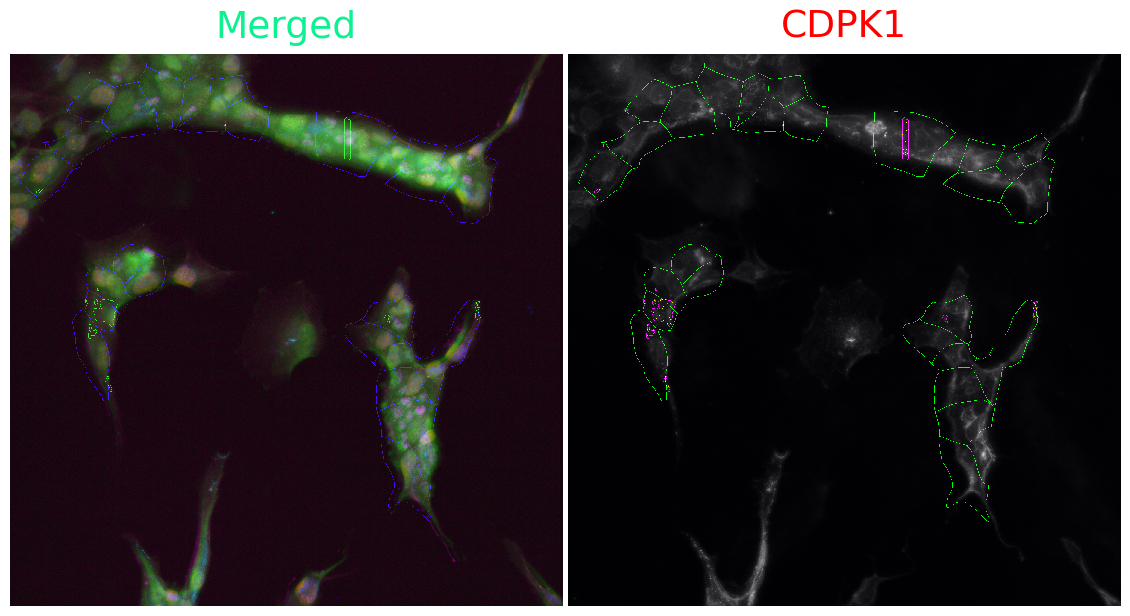

In [ ]:
# Segment vacuoles if enabled
if VACUOLE_DETECTION:
    print(f"Performing vacuole segmentation with {VACUOLE_CHANNEL}...")
    
    vacuole_masks, cell_vacuole_table, updated_cytoplasm_masks = segment_vacuoles(
        image=corrected_image,
        vacuole_channel_index=VACUOLE_CHANNEL_INDEX,
        nuclei_channel_index=VACUOLE_CHANNEL_INDEX, 
        cell_masks=cells,
        cytoplasm_masks=cytoplasms,
        min_size=VACUOLE_MIN_SIZE,
        max_size=VACUOLE_MAX_SIZE,
        nuclei_min_distance=5,
        nuclei_centroids=phenotype_minimal
    )
    cell_summary = cell_vacuole_table['cell_summary']
    vacuole_cell_mapping = cell_vacuole_table['vacuole_cell_mapping']
    
    # Print statistics
    print(f"Found vacuoles in {cell_summary['has_vacuole'].sum()} out of {len(cell_summary)} cells")
    print(f"Average vacuoles per cell with vacuoles: {cell_summary.loc[cell_summary['has_vacuole'], 'num_vacuoles'].mean():.2f}")
    print(f"Average vacuole area ratio: {cell_summary['vacuole_area_ratio'].mean():.4f}")
    print(f"Total nuclei detected within vacuoles: {cell_summary['total_nuclei_in_vacuoles'].sum()}")
    print(f"Number of multinucleated vacuoles: {cell_summary['multinucleated_vacuole_count'].sum()}")
    
    # Create standard visualizations
    print("Example microplots for vacuole channel and vacuole segmentation:")
    vacuole_cmap = random_cmap(num_colors=len(np.unique(vacuole_masks)))
    vacuole_microimages = [
        Microimage(
            corrected_image[VACUOLE_CHANNEL_INDEX],
            channel_names=VACUOLE_CHANNEL,
            cmaps="gray",
        ),
        Microimage(vacuole_masks, cmaps=vacuole_cmap, channel_names="Vacuoles"),
    ]
    vacuole_panel = create_micropanel(vacuole_microimages, add_channel_label=True)
    plt.show()
    
    # Create enhanced boundary visualization with peaks
    print("Enhanced visualization with cell boundaries, vacuole boundaries, and detected peaks:")
    boundary_panel = create_vacuole_boundary_visualization(
        corrected_image,
        VACUOLE_CHANNEL_INDEX,
        cell_masks=cells,
        vacuole_masks=vacuole_masks,
        vacuole_cell_mapping=vacuole_cell_mapping,
        channel_names=CHANNEL_NAMES,
        show_nuclei_peaks=True
    )
    plt.show()

In [ ]:
# Extract the two DataFrames from the dictionary
cell_summary_df = cell_vacuole_table['cell_summary']
vacuole_cell_mapping_df = cell_vacuole_table['vacuole_cell_mapping']

# Display the cell summary DataFrame
print("Cell Summary DataFrame:")
display(cell_summary_df)

# Display the vacuole-cell mapping DataFrame
print("\nVacuole-Cell Mapping DataFrame:")
display(vacuole_cell_mapping_df)

In [ ]:
print("Extracting phenotype features:")
phenotype_cp = extract_phenotype_cp_multichannel(
    aligned_image,
    nuclei=nuclei,
    cells=cells,
    wildcards=WILDCARDS,
    cytoplasms=cytoplasms,
    foci_channel=FOCI_CHANNEL,
    channel_names=CHANNEL_NAMES,
)

phenotype_cp

In [ ]:
# Extract phenotype features for vacuoles
vacuole_phenotype = extract_phenotype_vacuoles(
    aligned_image,
    vacuoles=vacuole_masks,
    vacuole_cell_mapping_df=cell_vacuole_table['vacuole_cell_mapping'],
    wildcards=WILDCARDS,
    foci_channel=FOCI_CHANNEL, 
    channel_names=CHANNEL_NAMES
)

In [ ]:
vacuole_phenotype

In [ ]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

## Add phenotype process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_phenotype_paramsearch` will systematically explore combinations of:

1. Size Parameters:
   - `nuclei_diameter`: Expected diameter of cell nuclei
   - `cell_diameter`: Expected diameter of cell cytoplasm
   
2. CellPose Parameters:
   - `flow_threshold`: Controls sensitivity of segmentation boundaries (default value 0.4)
     - Lower values: More aggressive segmentation, may over-segment
     - Higher values: More conservative, may miss cell boundaries
   - `cellprob_threshold`: Controls cell detection confidence (default value 0)
     - Lower values: Detects more potential cells, may include false positives
     - Higher values: More stringent detection, may miss weaker signals

The parameter search will:
1. Generate segmentations using different parameter combinations
2. Save results for each combination
3. Allow you to visually inspect results to choose optimal values
4. Help identify the best balance between over- and under-segmentation

Running these parameter searches is a time and resource intensive process and should only be done on a small subset of the tiles in the dataset.

In [ ]:
# # Add phenotype section
# config["phenotype"] = {
#     "foci_channel": FOCI_CHANNEL,
#     "channel_names": CHANNEL_NAMES,
#     "align": ALIGN,
#     "dapi_index": DAPI_INDEX,
#     "cyto_index": CYTO_INDEX,
#     "segmentation_method": SEGMENTATION_METHOD,
#     "segment_cells": SEGMENT_CELLS,
#     "reconcile": RECONCILE,
#     "gpu": GPU,
#     "mode": None,
# }

# # Add method-specific parameters based on segmentation method
# if SEGMENTATION_METHOD == "cellpose":
#     config["phenotype"].update({
#         "nuclei_diameter": NUCLEI_DIAMETER,
#         "cell_diameter": CELL_DIAMETER,
#         "flow_threshold": FLOW_THRESHOLD,
#         "cellprob_threshold": CELLPROB_THRESHOLD,
#         "cyto_model": CELLPOSE_MODEL,
#     })
# elif SEGMENTATION_METHOD == "microsam":
#     config["phenotype"].update({
#         "microsam_model": MICROSAM_MODEL,
#         "points_per_side": POINTS_PER_SIDE,
#         "points_per_batch": POINTS_PER_BATCH,
#         "stability_score_thresh": STABILITY_SCORE_THRESH,
#         "pred_iou_thresh": PRED_IOU_THRESH,
#     })
# elif SEGMENTATION_METHOD == "stardist":
#     config["phenotype"].update({
#         "stardist_model": STARDIST_MODEL,
#         "prob_thresh": PROB_THRESH,
#         "nms_thresh": NMS_THRESH,
#     })

# if ALIGN:
#     config["phenotype"]["alignments"] = ALIGNMENTS

# if VACUOLE_DETECTION:
#     config["phenotype"].update({
#         "vacuole_detection": VACUOLE_DETECTION,
#         "vacuole_channel_index": VACUOLE_CHANNEL_INDEX,
#         "vacuole_min_size": VACUOLE_MIN_SIZE,
#         "vacuole_max_size": VACUOLE_MAX_SIZE,
#     })

# # Write the updated configuration back with markdown-style comments
# with open(CONFIG_FILE_PATH, "w") as config_file:
#     # Write the introductory markdown-style comments
#     config_file.write(CONFIG_FILE_HEADER)

#     # Dump the updated YAML structure, keeping markdown comments for sections
#     yaml.dump(config, config_file, default_flow_style=False)